In [1]:
# Generic Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import warnings
from pathlib import Path

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Data Structure Setup
from collections import namedtuple
df_summary = namedtuple('df_summary', ['rows', 'cols', 'idx_list'])

In [3]:
# Read in data
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
test = pd.read_pickle(pickle_path / "test.pkl")
train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")

Data Frame Shapes
Test: (699, 2880)
Train: (1590, 2880)
Labels: (1590, 2880)


In [4]:
# Sum across labels df to determine how many times each house charged an electric car
df_a = pd.DataFrame(labels.sum(axis=1))
df_a.rename(columns= {0: 'sum'}, inplace=True)

# Map sums to Booleans
# True - Electric car was charged one or more times at the given house
# False - No electic cars charged at the 
df_a['bool'] = df_a['sum'].where(df_a['sum'] == 0, other=1)
df_a['bool'].replace({0:False, 1:True}, inplace=True)
df_aT = df_a.loc[df_a['bool'] == True]


## Transform/Engineer Training Data

In [5]:
# Summary stats for each training sample
stats = pd.DataFrame(index=train.index)
stats['sum'] = pd.DataFrame(train.sum(axis=1))
stats['min'] = pd.DataFrame(train.min(axis=1))
stats['max'] = pd.DataFrame(train.max(axis=1))
stats['avg'] = pd.DataFrame(train.mean(axis=1))

# Baseline for each training sample
# Per-house average of all data points < threshold
threshold = 2
temp = train.copy()
temp[temp > threshold] = np.NaN
stats['baseline'] = pd.DataFrame(temp.mean(axis=1))
del temp, threshold


Number of Outliers: 37
Percent Removed: 2.33%

                sum          min          max          avg     baseline
count   1553.000000  1553.000000  1553.000000  1553.000000  1541.000000
mean    3127.751678     0.180346     4.929341     1.086201     0.713194
std     2526.937885     0.387594     2.566797     0.877420     0.289931
min      814.774000     0.000000     0.553000     0.282908     0.005000
25%     1858.206000     0.026000     3.182000     0.645210     0.534529
50%     2417.102414     0.087000     4.391000     0.839272     0.643953
75%     3367.004114     0.170000     6.214256     1.169099     0.804457
max    30073.740000     5.248000    19.610000    10.442271     1.992000


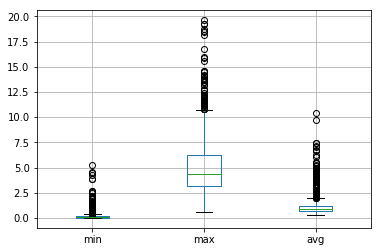

In [6]:
# Outliers: Max Meter Reading
try: del outliers
except NameError as e: pass

std = stats['max'].std()
mean = stats['max'].mean()
threshold = mean + (2 * std)
outliers = stats.loc[stats['max'] > threshold]

train_clean = train.drop(outliers.index)
stats_clean = stats.drop(outliers.index)

train_ct = train_summary.rows
cleaned_ct = train_clean.shape[0]
outlier_ct = outliers.shape[0]
print("Number of Outliers: {}".format(outlier_ct))
print("Percent Removed: {}%\n".format(round(outlier_ct/train_ct*100, 2)))

print(stats_clean.describe())
stats_clean.boxplot(column=['min', 'max', 'avg'])

## Testing Part A

In [7]:
# Split into features and classifications
X = train_clean.copy(deep=True)
y = df_a['bool'].drop(outliers.index, errors='ignore')

# Drop NA-containing rows from X
before = df_summary(X.shape[0], X.shape[1], X.index.tolist())
X = X.dropna()
after = df_summary(X.shape[0], X.shape[1], X.index.tolist())
print("{} Rows were dropped for NA reasons.".format(before.rows - after.rows))

# Drop corresponsing rows from y
removed_idx = []
for house_id in before.idx_list: 
    if house_id not in after.idx_list: 
        removed_idx.append(house_id)
y = y.drop(index=removed_idx)

# Scale the features between -1 and 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)                                    
X_scaled = scaler.transform(X)

# Split data into training and testing
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    random_state=0)


4 Rows were dropped for NA reasons.


In [8]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Solver = ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.858


## Time Series Modelling  
As the name suggests, TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

1. It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.  
2. Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.

**Time series isn't the best way to handle this because we aren't trying to predict what will happen in the future.** Also, Time series isn't typically a classification problem. However, time series analysis technique, like rolling statistics, are beneficial. 

In [9]:
# Create datetime stamps for each interval. 
# 30 min intervals, choose arbitrary start date 
# Alternative: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
from datetime import datetime 
from datetime import timedelta

start_dt = datetime(2000, 1, 1)
date_dict = {}
for idx, interval in enumerate(sorted(train.columns)):
    dt = start_dt + timedelta(minutes=(30*idx))
    date_dict.update({interval: dt})
    

Result: assume timeseries data is approx. stationary


Text(0.5, 1.0, 'Rolling Standard Deviation')

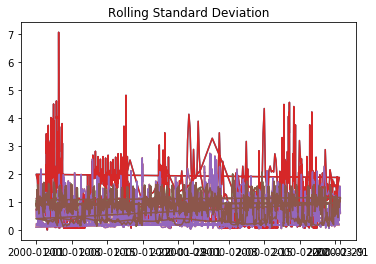

In [10]:
# Transpose s.t. each series represents a house
train_t = train_clean.T

# Replace interval labels with timestamps
# Both are arbitrary, timestamps enforce order dependence
train_t = train_t.rename(index=date_dict)

# Calculate rolling statistics
rolmean = train_t.rolling(window=48).mean()
rolstd = train_t.rolling(window=48).std()

# Plot random houses 
rand_house = random.choices(rolmean.columns.tolist(), k=3)
rolmean_samp = train_t.loc[:, rand_house]
rolstd_samp = train_t.loc[:, rand_house]

print("Result: assume timeseries data is approx. stationary")
# Plot rolling statistics:
mean = plt.plot(rolmean_samp)
plt.title('Rolling Mean')
# plt.show(block=False)

# mean = plt.plot(rolmean_samp, color='red', label='Rolling Mean')
std = plt.plot(rolstd_samp)
plt.title('Rolling Standard Deviation')
# plt.show(block=False)


## Logistic Regression with Feature Engineering
A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

In [11]:
rand_house = random.choices(rolmean.columns.tolist(), k=50)

In [12]:
# Drop Outliers
labels_clean = labels.drop(outliers.index)
train_clean = train.drop(outliers.index, index=0)

# Subset
labels_clean = labels_clean.loc[rand_house]
labels_clean.replace({0:False, 1:True}, inplace=True)
train_clean = train_clean.loc[rand_house]

In [13]:
# 7-day average
interval = 24 * 2 *7
feat_7d_avg = train_clean.rolling(window=interval, axis=1).mean()
# print(feat_7d_avg.head())

# 24-hour average
interval = 24 * 2
feat_24h_avg = train_clean.rolling(window=interval, axis=1).mean()
# print(feat_24h_avg.head())

# Calculate the change in demand between each time point (d-use/d-time)
train_diff = pd.DataFrame(index=train.index)
cols = list(train.columns.values)
for i, c2 in enumerate(cols): 
    if i == 0: pass # Skip the first element
    c1 = cols[i-1]
    train_diff[c2] = pd.DataFrame(abs(train[c2] - train[c1]))

# Max 24-hour differential
feat_24h_diff = train_diff.rolling(window=interval, axis=1).max()
# print(feat_24h_diff.head())

In [33]:
data_points = []
# For each house
for house_id in train_clean.index.tolist():
    # For each interval
    for idx, interval in enumerate(cols):
        temp_dict = {'house_id': house_id, 
                     'interval': interval, 
#                      'value': train_clean.at[house_id, interval],
#                      'diff': train_diff.at[house_id, interval],
#                      '7d_avg': feat_7d_avg.at[house_id, interval],
#                      '24h_avg': feat_24h_avg.at[house_id, interval], 
#                      '24h_max': feat_24h_diff.at[house_id, interval], 
#                      'label': labels_clean.at[house_id, interval]
                    }
        data_points.append(temp_dict)

features = pd.DataFrame(data_points)
print(features.head())

for idx in features.index.tolist():
    id = features.loc[idx].house_id
    int = features.loc[idx].interval
    value = train_clean[int].loc[id]
    if not isinstance(value, float): 
        print('\n', id, int)
        print(value)
    
    # features['value'] = train_clean.at[id, int]
#     features['diff'] = train_diff.at[id, int]
#     features['7d_avg'] = feat_7d_avg.at[id, int]
#     features['24h_avg'] = feat_24h_avg.at[id, int]
#     features['24h_max'] = feat_24h_diff.at[id, int]
#     features['label'] = labels_clean.at[id, int]

print(features.head())

   house_id    interval
0  11644977  Interval_1
1  11644977  Interval_2
2  11644977  Interval_3
3  11644977  Interval_4
4  11644977  Interval_5

 11633190 Interval_1
House ID
11633190    0.31
11633190    0.31
Name: Interval_1, dtype: float64

 11633190 Interval_2
House ID
11633190    0.283
11633190    0.283
Name: Interval_2, dtype: float64

 11633190 Interval_3
House ID
11633190    0.305
11633190    0.305
Name: Interval_3, dtype: float64

 11633190 Interval_4
House ID
11633190    0.44
11633190    0.44
Name: Interval_4, dtype: float64

 11633190 Interval_5
House ID
11633190    0.625
11633190    0.625
Name: Interval_5, dtype: float64

 11633190 Interval_6
House ID
11633190    0.65
11633190    0.65
Name: Interval_6, dtype: float64

 11633190 Interval_7
House ID
11633190    0.593
11633190    0.593
Name: Interval_7, dtype: float64

 11633190 Interval_8
House ID
11633190    1.235
11633190    1.235
Name: Interval_8, dtype: float64

 11633190 Interval_9
House ID
11633190    0.403
11633190    0

House ID
11633190    0.668
11633190    0.668
Name: Interval_168, dtype: float64

 11633190 Interval_169
House ID
11633190    1.55
11633190    1.55
Name: Interval_169, dtype: float64

 11633190 Interval_170
House ID
11633190    0.81
11633190    0.81
Name: Interval_170, dtype: float64

 11633190 Interval_171
House ID
11633190    0.698
11633190    0.698
Name: Interval_171, dtype: float64

 11633190 Interval_172
House ID
11633190    0.553
11633190    0.553
Name: Interval_172, dtype: float64

 11633190 Interval_173
House ID
11633190    0.47
11633190    0.47
Name: Interval_173, dtype: float64

 11633190 Interval_174
House ID
11633190    0.49
11633190    0.49
Name: Interval_174, dtype: float64

 11633190 Interval_175
House ID
11633190    0.455
11633190    0.455
Name: Interval_175, dtype: float64

 11633190 Interval_176
House ID
11633190    0.533
11633190    0.533
Name: Interval_176, dtype: float64

 11633190 Interval_177
House ID
11633190    1.045
11633190    1.045
Name: Interval_177, dtype: 

 11633190 Interval_311
House ID
11633190    0.703
11633190    0.703
Name: Interval_311, dtype: float64

 11633190 Interval_312
House ID
11633190    3.312012
11633190    3.312012
Name: Interval_312, dtype: float64

 11633190 Interval_313
House ID
11633190    1.610244
11633190    1.610244
Name: Interval_313, dtype: float64

 11633190 Interval_314
House ID
11633190    0.505
11633190    0.505
Name: Interval_314, dtype: float64

 11633190 Interval_315
House ID
11633190    0.575
11633190    0.575
Name: Interval_315, dtype: float64

 11633190 Interval_316
House ID
11633190    1.298
11633190    1.298
Name: Interval_316, dtype: float64

 11633190 Interval_317
House ID
11633190    0.92
11633190    0.92
Name: Interval_317, dtype: float64

 11633190 Interval_318
House ID
11633190    0.493
11633190    0.493
Name: Interval_318, dtype: float64

 11633190 Interval_319
House ID
11633190    0.47
11633190    0.47
Name: Interval_319, dtype: float64

 11633190 Interval_320
House ID
11633190    0.413
116331

 11633190 Interval_485
House ID
11633190    0.255
11633190    0.255
Name: Interval_485, dtype: float64

 11633190 Interval_486
House ID
11633190    0.285
11633190    0.285
Name: Interval_486, dtype: float64

 11633190 Interval_487
House ID
11633190    0.258
11633190    0.258
Name: Interval_487, dtype: float64

 11633190 Interval_488
House ID
11633190    0.278
11633190    0.278
Name: Interval_488, dtype: float64

 11633190 Interval_489
House ID
11633190    0.255
11633190    0.255
Name: Interval_489, dtype: float64

 11633190 Interval_490
House ID
11633190    0.273
11633190    0.273
Name: Interval_490, dtype: float64

 11633190 Interval_491
House ID
11633190    0.253
11633190    0.253
Name: Interval_491, dtype: float64

 11633190 Interval_492
House ID
11633190    3.212927
11633190    3.212927
Name: Interval_492, dtype: float64

 11633190 Interval_493
House ID
11633190    3.620256
11633190    3.620256
Name: Interval_493, dtype: float64

 11633190 Interval_494
House ID
11633190    1.742329

 11633190 Interval_657
House ID
11633190    2.685
11633190    2.685
Name: Interval_657, dtype: float64

 11633190 Interval_658
House ID
11633190    1.545
11633190    1.545
Name: Interval_658, dtype: float64

 11633190 Interval_659
House ID
11633190    1.055
11633190    1.055
Name: Interval_659, dtype: float64

 11633190 Interval_660
House ID
11633190    1.085
11633190    1.085
Name: Interval_660, dtype: float64

 11633190 Interval_661
House ID
11633190    1.448
11633190    1.448
Name: Interval_661, dtype: float64

 11633190 Interval_662
House ID
11633190    0.818
11633190    0.818
Name: Interval_662, dtype: float64

 11633190 Interval_663
House ID
11633190    0.57
11633190    0.57
Name: Interval_663, dtype: float64

 11633190 Interval_664
House ID
11633190    0.47
11633190    0.47
Name: Interval_664, dtype: float64

 11633190 Interval_665
House ID
11633190    0.588
11633190    0.588
Name: Interval_665, dtype: float64

 11633190 Interval_666
House ID
11633190    0.525
11633190    0.525


 11633190 Interval_811
House ID
11633190    1.833
11633190    1.833
Name: Interval_811, dtype: float64

 11633190 Interval_812
House ID
11633190    1.233
11633190    1.233
Name: Interval_812, dtype: float64

 11633190 Interval_813
House ID
11633190    0.385
11633190    0.385
Name: Interval_813, dtype: float64

 11633190 Interval_814
House ID
11633190    0.948
11633190    0.948
Name: Interval_814, dtype: float64

 11633190 Interval_815
House ID
11633190    0.293
11633190    0.293
Name: Interval_815, dtype: float64

 11633190 Interval_816
House ID
11633190    0.328
11633190    0.328
Name: Interval_816, dtype: float64

 11633190 Interval_817
House ID
11633190    0.29
11633190    0.29
Name: Interval_817, dtype: float64

 11633190 Interval_818
House ID
11633190    0.87
11633190    0.87
Name: Interval_818, dtype: float64

 11633190 Interval_819
House ID
11633190    0.525
11633190    0.525
Name: Interval_819, dtype: float64

 11633190 Interval_820
House ID
11633190    0.265
11633190    0.265


House ID
11633190    0.618
11633190    0.618
Name: Interval_973, dtype: float64

 11633190 Interval_974
House ID
11633190    1.47
11633190    1.47
Name: Interval_974, dtype: float64

 11633190 Interval_975
House ID
11633190    0.678
11633190    0.678
Name: Interval_975, dtype: float64

 11633190 Interval_976
House ID
11633190    0.438
11633190    0.438
Name: Interval_976, dtype: float64

 11633190 Interval_977
House ID
11633190    0.335
11633190    0.335
Name: Interval_977, dtype: float64

 11633190 Interval_978
House ID
11633190    0.31
11633190    0.31
Name: Interval_978, dtype: float64

 11633190 Interval_979
House ID
11633190    0.295
11633190    0.295
Name: Interval_979, dtype: float64

 11633190 Interval_980
House ID
11633190    0.308
11633190    0.308
Name: Interval_980, dtype: float64

 11633190 Interval_981
House ID
11633190    0.313
11633190    0.313
Name: Interval_981, dtype: float64

 11633190 Interval_982
House ID
11633190    0.305
11633190    0.305
Name: Interval_982, dty

Name: Interval_1185, dtype: float64

 11633190 Interval_1186
House ID
11633190    2.993
11633190    2.993
Name: Interval_1186, dtype: float64

 11633190 Interval_1187
House ID
11633190    4.18
11633190    4.18
Name: Interval_1187, dtype: float64

 11633190 Interval_1188
House ID
11633190    5.073
11633190    5.073
Name: Interval_1188, dtype: float64

 11633190 Interval_1189
House ID
11633190    2.91
11633190    2.91
Name: Interval_1189, dtype: float64

 11633190 Interval_1190
House ID
11633190    2.283
11633190    2.283
Name: Interval_1190, dtype: float64

 11633190 Interval_1191
House ID
11633190    1.623
11633190    1.623
Name: Interval_1191, dtype: float64

 11633190 Interval_1192
House ID
11633190    3.52
11633190    3.52
Name: Interval_1192, dtype: float64

 11633190 Interval_1193
House ID
11633190    2.76
11633190    2.76
Name: Interval_1193, dtype: float64

 11633190 Interval_1194
House ID
11633190    2.548
11633190    2.548
Name: Interval_1194, dtype: float64

 11633190 Interva

 11633190 Interval_1417
House ID
11633190    0.328
11633190    0.328
Name: Interval_1417, dtype: float64

 11633190 Interval_1418
House ID
11633190    0.285
11633190    0.285
Name: Interval_1418, dtype: float64

 11633190 Interval_1419
House ID
11633190    0.298
11633190    0.298
Name: Interval_1419, dtype: float64

 11633190 Interval_1420
House ID
11633190    0.23
11633190    0.23
Name: Interval_1420, dtype: float64

 11633190 Interval_1421
House ID
11633190    0.37
11633190    0.37
Name: Interval_1421, dtype: float64

 11633190 Interval_1422
House ID
11633190    0.333
11633190    0.333
Name: Interval_1422, dtype: float64

 11633190 Interval_1423
House ID
11633190    0.258
11633190    0.258
Name: Interval_1423, dtype: float64

 11633190 Interval_1424
House ID
11633190    0.565
11633190    0.565
Name: Interval_1424, dtype: float64

 11633190 Interval_1425
House ID
11633190    0.72
11633190    0.72
Name: Interval_1425, dtype: float64

 11633190 Interval_1426
House ID
11633190    0.41
11

 11633190 Interval_1560
House ID
11633190    1.528
11633190    1.528
Name: Interval_1560, dtype: float64

 11633190 Interval_1561
House ID
11633190    0.578
11633190    0.578
Name: Interval_1561, dtype: float64

 11633190 Interval_1562
House ID
11633190    0.555
11633190    0.555
Name: Interval_1562, dtype: float64

 11633190 Interval_1563
House ID
11633190    0.46
11633190    0.46
Name: Interval_1563, dtype: float64

 11633190 Interval_1564
House ID
11633190    0.438
11633190    0.438
Name: Interval_1564, dtype: float64

 11633190 Interval_1565
House ID
11633190    0.535
11633190    0.535
Name: Interval_1565, dtype: float64

 11633190 Interval_1566
House ID
11633190    0.525
11633190    0.525
Name: Interval_1566, dtype: float64

 11633190 Interval_1567
House ID
11633190    0.728
11633190    0.728
Name: Interval_1567, dtype: float64

 11633190 Interval_1568
House ID
11633190    1.46
11633190    1.46
Name: Interval_1568, dtype: float64

 11633190 Interval_1569
House ID
11633190    1.338

House ID
11633190    0.27
11633190    0.27
Name: Interval_1753, dtype: float64

 11633190 Interval_1754
House ID
11633190    0.248
11633190    0.248
Name: Interval_1754, dtype: float64

 11633190 Interval_1755
House ID
11633190    0.203
11633190    0.203
Name: Interval_1755, dtype: float64

 11633190 Interval_1756
House ID
11633190    0.265
11633190    0.265
Name: Interval_1756, dtype: float64

 11633190 Interval_1757
House ID
11633190    0.43
11633190    0.43
Name: Interval_1757, dtype: float64

 11633190 Interval_1758
House ID
11633190    0.913
11633190    0.913
Name: Interval_1758, dtype: float64

 11633190 Interval_1759
House ID
11633190    0.365
11633190    0.365
Name: Interval_1759, dtype: float64

 11633190 Interval_1760
House ID
11633190    0.425
11633190    0.425
Name: Interval_1760, dtype: float64

 11633190 Interval_1761
House ID
11633190    0.24
11633190    0.24
Name: Interval_1761, dtype: float64

 11633190 Interval_1762
House ID
11633190    0.42
11633190    0.42
Name: Int

 11633190 Interval_1917
House ID
11633190    0.39
11633190    0.39
Name: Interval_1917, dtype: float64

 11633190 Interval_1918
House ID
11633190    0.445
11633190    0.445
Name: Interval_1918, dtype: float64

 11633190 Interval_1919
House ID
11633190    0.378
11633190    0.378
Name: Interval_1919, dtype: float64

 11633190 Interval_1920
House ID
11633190    0.405
11633190    0.405
Name: Interval_1920, dtype: float64

 11633190 Interval_1921
House ID
11633190    0.345
11633190    0.345
Name: Interval_1921, dtype: float64

 11633190 Interval_1922
House ID
11633190    0.42
11633190    0.42
Name: Interval_1922, dtype: float64

 11633190 Interval_1923
House ID
11633190    0.883
11633190    0.883
Name: Interval_1923, dtype: float64

 11633190 Interval_1924
House ID
11633190    0.34
11633190    0.34
Name: Interval_1924, dtype: float64

 11633190 Interval_1925
House ID
11633190    0.325
11633190    0.325
Name: Interval_1925, dtype: float64

 11633190 Interval_1926
House ID
11633190    0.213
1

 11633190 Interval_2060
House ID
11633190    0.4
11633190    0.4
Name: Interval_2060, dtype: float64

 11633190 Interval_2061
House ID
11633190    0.43
11633190    0.43
Name: Interval_2061, dtype: float64

 11633190 Interval_2062
House ID
11633190    1.098
11633190    1.098
Name: Interval_2062, dtype: float64

 11633190 Interval_2063
House ID
11633190    2.57
11633190    2.57
Name: Interval_2063, dtype: float64

 11633190 Interval_2064
House ID
11633190    0.593
11633190    0.593
Name: Interval_2064, dtype: float64

 11633190 Interval_2065
House ID
11633190    0.335
11633190    0.335
Name: Interval_2065, dtype: float64

 11633190 Interval_2066
House ID
11633190    0.295
11633190    0.295
Name: Interval_2066, dtype: float64

 11633190 Interval_2067
House ID
11633190    1.265
11633190    1.265
Name: Interval_2067, dtype: float64

 11633190 Interval_2068
House ID
11633190    0.485
11633190    0.485
Name: Interval_2068, dtype: float64

 11633190 Interval_2069
House ID
11633190    0.398
116

House ID
11633190    0.383
11633190    0.383
Name: Interval_2252, dtype: float64

 11633190 Interval_2253
House ID
11633190    0.345
11633190    0.345
Name: Interval_2253, dtype: float64

 11633190 Interval_2254
House ID
11633190    1.063
11633190    1.063
Name: Interval_2254, dtype: float64

 11633190 Interval_2255
House ID
11633190    0.365
11633190    0.365
Name: Interval_2255, dtype: float64

 11633190 Interval_2256
House ID
11633190    0.333
11633190    0.333
Name: Interval_2256, dtype: float64

 11633190 Interval_2257
House ID
11633190    0.373
11633190    0.373
Name: Interval_2257, dtype: float64

 11633190 Interval_2258
House ID
11633190    0.333
11633190    0.333
Name: Interval_2258, dtype: float64

 11633190 Interval_2259
House ID
11633190    0.345
11633190    0.345
Name: Interval_2259, dtype: float64

 11633190 Interval_2260
House ID
11633190    0.258
11633190    0.258
Name: Interval_2260, dtype: float64

 11633190 Interval_2261
House ID
11633190    0.388
11633190    0.388
N


 11633190 Interval_2435
House ID
11633190    2.278
11633190    2.278
Name: Interval_2435, dtype: float64

 11633190 Interval_2436
House ID
11633190    1.738
11633190    1.738
Name: Interval_2436, dtype: float64

 11633190 Interval_2437
House ID
11633190    1.31
11633190    1.31
Name: Interval_2437, dtype: float64

 11633190 Interval_2438
House ID
11633190    2.935759
11633190    2.935759
Name: Interval_2438, dtype: float64

 11633190 Interval_2439
House ID
11633190    0.868
11633190    0.868
Name: Interval_2439, dtype: float64

 11633190 Interval_2440
House ID
11633190    0.93
11633190    0.93
Name: Interval_2440, dtype: float64

 11633190 Interval_2441
House ID
11633190    1.12
11633190    1.12
Name: Interval_2441, dtype: float64

 11633190 Interval_2442
House ID
11633190    0.538
11633190    0.538
Name: Interval_2442, dtype: float64

 11633190 Interval_2443
House ID
11633190    0.538
11633190    0.538
Name: Interval_2443, dtype: float64

 11633190 Interval_2444
House ID
11633190    

 11633190 Interval_2604
House ID
11633190    0.543
11633190    0.543
Name: Interval_2604, dtype: float64

 11633190 Interval_2605
House ID
11633190    0.79
11633190    0.79
Name: Interval_2605, dtype: float64

 11633190 Interval_2606
House ID
11633190    1.52
11633190    1.52
Name: Interval_2606, dtype: float64

 11633190 Interval_2607
House ID
11633190    2.065
11633190    2.065
Name: Interval_2607, dtype: float64

 11633190 Interval_2608
House ID
11633190    0.71
11633190    0.71
Name: Interval_2608, dtype: float64

 11633190 Interval_2609
House ID
11633190    0.288
11633190    0.288
Name: Interval_2609, dtype: float64

 11633190 Interval_2610
House ID
11633190    0.268
11633190    0.268
Name: Interval_2610, dtype: float64

 11633190 Interval_2611
House ID
11633190    0.413
11633190    0.413
Name: Interval_2611, dtype: float64

 11633190 Interval_2612
House ID
11633190    0.418
11633190    0.418
Name: Interval_2612, dtype: float64

 11633190 Interval_2613
House ID
11633190    0.77
11

House ID
11633190    0.508
11633190    0.508
Name: Interval_2809, dtype: float64

 11633190 Interval_2810
House ID
11633190    1.345
11633190    1.345
Name: Interval_2810, dtype: float64

 11633190 Interval_2811
House ID
11633190    1.35
11633190    1.35
Name: Interval_2811, dtype: float64

 11633190 Interval_2812
House ID
11633190    0.508
11633190    0.508
Name: Interval_2812, dtype: float64

 11633190 Interval_2813
House ID
11633190    0.525
11633190    0.525
Name: Interval_2813, dtype: float64

 11633190 Interval_2814
House ID
11633190    0.408
11633190    0.408
Name: Interval_2814, dtype: float64

 11633190 Interval_2815
House ID
11633190    0.348
11633190    0.348
Name: Interval_2815, dtype: float64

 11633190 Interval_2816
House ID
11633190    0.358
11633190    0.358
Name: Interval_2816, dtype: float64

 11633190 Interval_2817
House ID
11633190    0.445
11633190    0.445
Name: Interval_2817, dtype: float64

 11633190 Interval_2818
House ID
11633190    0.688
11633190    0.688
Nam

 11633190 Interval_179
House ID
11633190    2.028337
11633190    2.028337
Name: Interval_179, dtype: float64

 11633190 Interval_180
House ID
11633190    5.407256
11633190    5.407256
Name: Interval_180, dtype: float64

 11633190 Interval_181
House ID
11633190    4.865256
11633190    4.865256
Name: Interval_181, dtype: float64

 11633190 Interval_182
House ID
11633190    4.172256
11633190    4.172256
Name: Interval_182, dtype: float64

 11633190 Interval_183
House ID
11633190    4.286919
11633190    4.286919
Name: Interval_183, dtype: float64

 11633190 Interval_184
House ID
11633190    1.078
11633190    1.078
Name: Interval_184, dtype: float64

 11633190 Interval_185
House ID
11633190    1.195
11633190    1.195
Name: Interval_185, dtype: float64

 11633190 Interval_186
House ID
11633190    1.515
11633190    1.515
Name: Interval_186, dtype: float64

 11633190 Interval_187
House ID
11633190    0.508
11633190    0.508
Name: Interval_187, dtype: float64

 11633190 Interval_188
House ID
11

 11633190 Interval_304
House ID
11633190    0.358
11633190    0.358
Name: Interval_304, dtype: float64

 11633190 Interval_305
House ID
11633190    0.393
11633190    0.393
Name: Interval_305, dtype: float64

 11633190 Interval_306
House ID
11633190    0.29
11633190    0.29
Name: Interval_306, dtype: float64

 11633190 Interval_307
House ID
11633190    0.678
11633190    0.678
Name: Interval_307, dtype: float64

 11633190 Interval_308
House ID
11633190    0.548
11633190    0.548
Name: Interval_308, dtype: float64

 11633190 Interval_309
House ID
11633190    0.955
11633190    0.955
Name: Interval_309, dtype: float64

 11633190 Interval_310
House ID
11633190    1.288
11633190    1.288
Name: Interval_310, dtype: float64

 11633190 Interval_311
House ID
11633190    0.703
11633190    0.703
Name: Interval_311, dtype: float64

 11633190 Interval_312
House ID
11633190    3.312012
11633190    3.312012
Name: Interval_312, dtype: float64

 11633190 Interval_313
House ID
11633190    1.610244
1163319

 11633190 Interval_450
House ID
11633190    0.513
11633190    0.513
Name: Interval_450, dtype: float64

 11633190 Interval_451
House ID
11633190    0.53
11633190    0.53
Name: Interval_451, dtype: float64

 11633190 Interval_452
House ID
11633190    0.698
11633190    0.698
Name: Interval_452, dtype: float64

 11633190 Interval_453
House ID
11633190    1.345
11633190    1.345
Name: Interval_453, dtype: float64

 11633190 Interval_454
House ID
11633190    2.62
11633190    2.62
Name: Interval_454, dtype: float64

 11633190 Interval_455
House ID
11633190    3.34
11633190    3.34
Name: Interval_455, dtype: float64

 11633190 Interval_456
House ID
11633190    2.99
11633190    2.99
Name: Interval_456, dtype: float64

 11633190 Interval_457
House ID
11633190    3.018
11633190    3.018
Name: Interval_457, dtype: float64

 11633190 Interval_458
House ID
11633190    2.895
11633190    2.895
Name: Interval_458, dtype: float64

 11633190 Interval_459
House ID
11633190    2.928
11633190    2.928
Name

 11633190 Interval_613
House ID
11633190    2.653
11633190    2.653
Name: Interval_613, dtype: float64

 11633190 Interval_614
House ID
11633190    1.513
11633190    1.513
Name: Interval_614, dtype: float64

 11633190 Interval_615
House ID
11633190    0.643
11633190    0.643
Name: Interval_615, dtype: float64

 11633190 Interval_616
House ID
11633190    0.555
11633190    0.555
Name: Interval_616, dtype: float64

 11633190 Interval_617
House ID
11633190    0.59
11633190    0.59
Name: Interval_617, dtype: float64

 11633190 Interval_618
House ID
11633190    0.503
11633190    0.503
Name: Interval_618, dtype: float64

 11633190 Interval_619
House ID
11633190    0.513
11633190    0.513
Name: Interval_619, dtype: float64

 11633190 Interval_620
House ID
11633190    1.445
11633190    1.445
Name: Interval_620, dtype: float64

 11633190 Interval_621
House ID
11633190    0.68
11633190    0.68
Name: Interval_621, dtype: float64

 11633190 Interval_622
House ID
11633190    0.453
11633190    0.453


House ID
11633190    2.305
11633190    2.305
Name: Interval_762, dtype: float64

 11633190 Interval_763
House ID
11633190    2.13
11633190    2.13
Name: Interval_763, dtype: float64

 11633190 Interval_764
House ID
11633190    1.775
11633190    1.775
Name: Interval_764, dtype: float64

 11633190 Interval_765
House ID
11633190    1.48
11633190    1.48
Name: Interval_765, dtype: float64

 11633190 Interval_766
House ID
11633190    1.503
11633190    1.503
Name: Interval_766, dtype: float64

 11633190 Interval_767
House ID
11633190    1.24
11633190    1.24
Name: Interval_767, dtype: float64

 11633190 Interval_768
House ID
11633190    1.868
11633190    1.868
Name: Interval_768, dtype: float64

 11633190 Interval_769
House ID
11633190    1.13
11633190    1.13
Name: Interval_769, dtype: float64

 11633190 Interval_770
House ID
11633190    1.03
11633190    1.03
Name: Interval_770, dtype: float64

 11633190 Interval_771
House ID
11633190    0.745
11633190    0.745
Name: Interval_771, dtype: fl

Name: Interval_928, dtype: float64

 11633190 Interval_929
House ID
11633190    0.405
11633190    0.405
Name: Interval_929, dtype: float64

 11633190 Interval_930
House ID
11633190    0.313
11633190    0.313
Name: Interval_930, dtype: float64

 11633190 Interval_931
House ID
11633190    0.265
11633190    0.265
Name: Interval_931, dtype: float64

 11633190 Interval_932
House ID
11633190    0.248
11633190    0.248
Name: Interval_932, dtype: float64

 11633190 Interval_933
House ID
11633190    0.858
11633190    0.858
Name: Interval_933, dtype: float64

 11633190 Interval_934
House ID
11633190    0.638
11633190    0.638
Name: Interval_934, dtype: float64

 11633190 Interval_935
House ID
11633190    0.303
11633190    0.303
Name: Interval_935, dtype: float64

 11633190 Interval_936
House ID
11633190    0.328
11633190    0.328
Name: Interval_936, dtype: float64

 11633190 Interval_937
House ID
11633190    0.313
11633190    0.313
Name: Interval_937, dtype: float64

 11633190 Interval_938
House

 11633190 Interval_1147
House ID
11633190    0.545
11633190    0.545
Name: Interval_1147, dtype: float64

 11633190 Interval_1148
House ID
11633190    0.833
11633190    0.833
Name: Interval_1148, dtype: float64

 11633190 Interval_1149
House ID
11633190    0.31
11633190    0.31
Name: Interval_1149, dtype: float64

 11633190 Interval_1150
House ID
11633190    0.245
11633190    0.245
Name: Interval_1150, dtype: float64

 11633190 Interval_1151
House ID
11633190    0.29
11633190    0.29
Name: Interval_1151, dtype: float64

 11633190 Interval_1152
House ID
11633190    0.255
11633190    0.255
Name: Interval_1152, dtype: float64

 11633190 Interval_1153
House ID
11633190    0.278
11633190    0.278
Name: Interval_1153, dtype: float64

 11633190 Interval_1154
House ID
11633190    0.265
11633190    0.265
Name: Interval_1154, dtype: float64

 11633190 Interval_1155
House ID
11633190    0.22
11633190    0.22
Name: Interval_1155, dtype: float64

 11633190 Interval_1156
House ID
11633190    0.555
1

 11633190 Interval_1303
House ID
11633190    0.288
11633190    0.288
Name: Interval_1303, dtype: float64

 11633190 Interval_1304
House ID
11633190    0.245
11633190    0.245
Name: Interval_1304, dtype: float64

 11633190 Interval_1305
House ID
11633190    0.293
11633190    0.293
Name: Interval_1305, dtype: float64

 11633190 Interval_1306
House ID
11633190    0.243
11633190    0.243
Name: Interval_1306, dtype: float64

 11633190 Interval_1307
House ID
11633190    0.52
11633190    0.52
Name: Interval_1307, dtype: float64

 11633190 Interval_1308
House ID
11633190    0.378
11633190    0.378
Name: Interval_1308, dtype: float64

 11633190 Interval_1309
House ID
11633190    0.338
11633190    0.338
Name: Interval_1309, dtype: float64

 11633190 Interval_1310
House ID
11633190    0.415
11633190    0.415
Name: Interval_1310, dtype: float64

 11633190 Interval_1311
House ID
11633190    0.48
11633190    0.48
Name: Interval_1311, dtype: float64

 11633190 Interval_1312
House ID
11633190    0.553

Name: Interval_1496, dtype: float64

 11633190 Interval_1497
House ID
11633190    0.268
11633190    0.268
Name: Interval_1497, dtype: float64

 11633190 Interval_1498
House ID
11633190    0.22
11633190    0.22
Name: Interval_1498, dtype: float64

 11633190 Interval_1499
House ID
11633190    0.43
11633190    0.43
Name: Interval_1499, dtype: float64

 11633190 Interval_1500
House ID
11633190    0.298
11633190    0.298
Name: Interval_1500, dtype: float64

 11633190 Interval_1501
House ID
11633190    0.273
11633190    0.273
Name: Interval_1501, dtype: float64

 11633190 Interval_1502
House ID
11633190    0.308
11633190    0.308
Name: Interval_1502, dtype: float64

 11633190 Interval_1503
House ID
11633190    0.263
11633190    0.263
Name: Interval_1503, dtype: float64

 11633190 Interval_1504
House ID
11633190    0.243
11633190    0.243
Name: Interval_1504, dtype: float64

 11633190 Interval_1505
House ID
11633190    0.36
11633190    0.36
Name: Interval_1505, dtype: float64

 11633190 Inter

 11633190 Interval_1634
House ID
11633190    0.373
11633190    0.373
Name: Interval_1634, dtype: float64

 11633190 Interval_1635
House ID
11633190    0.275
11633190    0.275
Name: Interval_1635, dtype: float64

 11633190 Interval_1636
House ID
11633190    0.23
11633190    0.23
Name: Interval_1636, dtype: float64

 11633190 Interval_1637
House ID
11633190    0.313
11633190    0.313
Name: Interval_1637, dtype: float64

 11633190 Interval_1638
House ID
11633190    0.213
11633190    0.213
Name: Interval_1638, dtype: float64

 11633190 Interval_1639
House ID
11633190    0.245
11633190    0.245
Name: Interval_1639, dtype: float64

 11633190 Interval_1640
House ID
11633190    0.243
11633190    0.243
Name: Interval_1640, dtype: float64

 11633190 Interval_1641
House ID
11633190    0.24
11633190    0.24
Name: Interval_1641, dtype: float64

 11633190 Interval_1642
House ID
11633190    0.245
11633190    0.245
Name: Interval_1642, dtype: float64

 11633190 Interval_1643
House ID
11633190    0.233

Name: Interval_1790, dtype: float64

 11633190 Interval_1791
House ID
11633190    0.488
11633190    0.488
Name: Interval_1791, dtype: float64

 11633190 Interval_1792
House ID
11633190    0.968
11633190    0.968
Name: Interval_1792, dtype: float64

 11633190 Interval_1793
House ID
11633190    0.448
11633190    0.448
Name: Interval_1793, dtype: float64

 11633190 Interval_1794
House ID
11633190    0.45
11633190    0.45
Name: Interval_1794, dtype: float64

 11633190 Interval_1795
House ID
11633190    0.413
11633190    0.413
Name: Interval_1795, dtype: float64

 11633190 Interval_1796
House ID
11633190    0.74
11633190    0.74
Name: Interval_1796, dtype: float64

 11633190 Interval_1797
House ID
11633190    0.525
11633190    0.525
Name: Interval_1797, dtype: float64

 11633190 Interval_1798
House ID
11633190    0.56
11633190    0.56
Name: Interval_1798, dtype: float64

 11633190 Interval_1799
House ID
11633190    0.63
11633190    0.63
Name: Interval_1799, dtype: float64

 11633190 Interva

 11633190 Interval_1928
House ID
11633190    0.233
11633190    0.233
Name: Interval_1928, dtype: float64

 11633190 Interval_1929
House ID
11633190    0.258
11633190    0.258
Name: Interval_1929, dtype: float64

 11633190 Interval_1930
House ID
11633190    0.228
11633190    0.228
Name: Interval_1930, dtype: float64

 11633190 Interval_1931
House ID
11633190    0.518
11633190    0.518
Name: Interval_1931, dtype: float64

 11633190 Interval_1932
House ID
11633190    0.29
11633190    0.29
Name: Interval_1932, dtype: float64

 11633190 Interval_1933
House ID
11633190    0.458
11633190    0.458
Name: Interval_1933, dtype: float64

 11633190 Interval_1934
House ID
11633190    0.543
11633190    0.543
Name: Interval_1934, dtype: float64

 11633190 Interval_1935
House ID
11633190    0.583
11633190    0.583
Name: Interval_1935, dtype: float64

 11633190 Interval_1936
House ID
11633190    0.63
11633190    0.63
Name: Interval_1936, dtype: float64

 11633190 Interval_1937
House ID
11633190    0.685

 11633190 Interval_2105
House ID
11633190    0.773
11633190    0.773
Name: Interval_2105, dtype: float64

 11633190 Interval_2106
House ID
11633190    2.7
11633190    2.7
Name: Interval_2106, dtype: float64

 11633190 Interval_2107
House ID
11633190    1.315
11633190    1.315
Name: Interval_2107, dtype: float64

 11633190 Interval_2108
House ID
11633190    0.708
11633190    0.708
Name: Interval_2108, dtype: float64

 11633190 Interval_2109
House ID
11633190    0.695
11633190    0.695
Name: Interval_2109, dtype: float64

 11633190 Interval_2110
House ID
11633190    0.28
11633190    0.28
Name: Interval_2110, dtype: float64

 11633190 Interval_2111
House ID
11633190    0.268
11633190    0.268
Name: Interval_2111, dtype: float64

 11633190 Interval_2112
House ID
11633190    0.298
11633190    0.298
Name: Interval_2112, dtype: float64

 11633190 Interval_2113
House ID
11633190    0.333
11633190    0.333
Name: Interval_2113, dtype: float64

 11633190 Interval_2114
House ID
11633190    0.248
1

Name: Interval_2302, dtype: float64

 11633190 Interval_2303
House ID
11633190    0.79
11633190    0.79
Name: Interval_2303, dtype: float64

 11633190 Interval_2304
House ID
11633190    0.395
11633190    0.395
Name: Interval_2304, dtype: float64

 11633190 Interval_2305
House ID
11633190    2.774182
11633190    2.774182
Name: Interval_2305, dtype: float64

 11633190 Interval_2306
House ID
11633190    1.221074
11633190    1.221074
Name: Interval_2306, dtype: float64

 11633190 Interval_2307
House ID
11633190    0.263
11633190    0.263
Name: Interval_2307, dtype: float64

 11633190 Interval_2308
House ID
11633190    0.258
11633190    0.258
Name: Interval_2308, dtype: float64

 11633190 Interval_2309
House ID
11633190    0.358
11633190    0.358
Name: Interval_2309, dtype: float64

 11633190 Interval_2310
House ID
11633190    0.903
11633190    0.903
Name: Interval_2310, dtype: float64

 11633190 Interval_2311
House ID
11633190    0.298
11633190    0.298
Name: Interval_2311, dtype: float64


 11633190 Interval_2478
House ID
11633190    2.793
11633190    2.793
Name: Interval_2478, dtype: float64

 11633190 Interval_2479
House ID
11633190    2.778
11633190    2.778
Name: Interval_2479, dtype: float64

 11633190 Interval_2480
House ID
11633190    2.79
11633190    2.79
Name: Interval_2480, dtype: float64

 11633190 Interval_2481
House ID
11633190    1.553
11633190    1.553
Name: Interval_2481, dtype: float64

 11633190 Interval_2482
House ID
11633190    1.16
11633190    1.16
Name: Interval_2482, dtype: float64

 11633190 Interval_2483
House ID
11633190    3.498
11633190    3.498
Name: Interval_2483, dtype: float64

 11633190 Interval_2484
House ID
11633190    4.04
11633190    4.04
Name: Interval_2484, dtype: float64

 11633190 Interval_2485
House ID
11633190    4.558193
11633190    4.558193
Name: Interval_2485, dtype: float64

 11633190 Interval_2486
House ID
11633190    6.080063
11633190    6.080063
Name: Interval_2486, dtype: float64

 11633190 Interval_2487
House ID
1163319

 11633190 Interval_2677
House ID
11633190    1.2
11633190    1.2
Name: Interval_2677, dtype: float64

 11633190 Interval_2678
House ID
11633190    0.855
11633190    0.855
Name: Interval_2678, dtype: float64

 11633190 Interval_2679
House ID
11633190    1.585
11633190    1.585
Name: Interval_2679, dtype: float64

 11633190 Interval_2680
House ID
11633190    0.778
11633190    0.778
Name: Interval_2680, dtype: float64

 11633190 Interval_2681
House ID
11633190    0.61
11633190    0.61
Name: Interval_2681, dtype: float64

 11633190 Interval_2682
House ID
11633190    0.82
11633190    0.82
Name: Interval_2682, dtype: float64

 11633190 Interval_2683
House ID
11633190    0.975
11633190    0.975
Name: Interval_2683, dtype: float64

 11633190 Interval_2684
House ID
11633190    0.4
11633190    0.4
Name: Interval_2684, dtype: float64

 11633190 Interval_2685
House ID
11633190    0.375
11633190    0.375
Name: Interval_2685, dtype: float64

 11633190 Interval_2686
House ID
11633190    0.365
1163319

 11633190 Interval_2846
House ID
11633190    0.478
11633190    0.478
Name: Interval_2846, dtype: float64

 11633190 Interval_2847
House ID
11633190    0.35
11633190    0.35
Name: Interval_2847, dtype: float64

 11633190 Interval_2848
House ID
11633190    0.358
11633190    0.358
Name: Interval_2848, dtype: float64

 11633190 Interval_2849
House ID
11633190    1.555
11633190    1.555
Name: Interval_2849, dtype: float64

 11633190 Interval_2850
House ID
11633190    0.488
11633190    0.488
Name: Interval_2850, dtype: float64

 11633190 Interval_2851
House ID
11633190    1.825
11633190    1.825
Name: Interval_2851, dtype: float64

 11633190 Interval_2852
House ID
11633190    1.178
11633190    1.178
Name: Interval_2852, dtype: float64

 11633190 Interval_2853
House ID
11633190    0.58
11633190    0.58
Name: Interval_2853, dtype: float64

 11633190 Interval_2854
House ID
11633190    0.553
11633190    0.553
Name: Interval_2854, dtype: float64

 11633190 Interval_2855
House ID
11633190    0.92


In [ ]:
# Split into features and classifications
features_in_model = ['value', 'diff', '7d_avg', '24h_avg', '24h_max']
X = features[features_in_model]
y = features['label']

# Drop NA-containing rows from X
before = df_summary(X.shape[0], X.shape[1], X.index.tolist())
X = X.dropna(axis=0)
after = df_summary(X.shape[0], X.shape[1], X.index.tolist())
print("{} Rows were dropped for NA reasons.".format(before.rows - after.rows))

# Drop corresponsing rows from y
removed_idx = []
for house_id in before.idx_list: 
    if house_id not in after.idx_list: 
        removed_idx.append(house_id)
y = y.drop(index=removed_idx)


In [21]:
X_new = X
y_new = y

print(type(X))
print(X.shape)

# print(X.head())
print(X_new.describe())

# 'value', 'diff', '7d_avg', '24h_avg', '24h_max'
# print(X_new['value'].value_counts())
# print(X_new['value'].value_counts())
print("\n\n")
print(X_new.loc[5810])

<class 'pandas.core.frame.DataFrame'>
(127826, 5)
                diff        24h_max
count  127826.000000  127826.000000
mean        0.235018       1.549014
std         0.428648       1.060101
min         0.000000       0.001000
25%         0.020000       0.822000
50%         0.069000       1.258000
75%         0.258000       1.995000
max         8.113000       8.113000



value      House ID
11633190    0.275
11633190    0.275
N...
diff                                                   0.403
7d_avg     House ID
11633190   NaN
11633190   NaN
Name: I...
24h_avg    House ID
11633190    0.618047
11633190    0.61...
24h_max                                              2.34977
Name: 5810, dtype: object


In [19]:
# Scale the features between -1 and 1
from sklearn.preprocessing import StandardScaler

chunks = (X.shape[0] - 1) // 50 + 1
for i in range(chunks):
    try: 
        X_new = X.iloc[i*50:(i+1)*50, :]
        scaler = StandardScaler().fit(X_new)  

    except ValueError as e: 
        print(e)
        print(X_new)
        break
        
    

setting an array element with a sequence.
                                                  value   diff  \
5720                                              3.075  0.570   
5721                                              1.677  1.398   
5722                                              0.789  0.888   
5723                                               1.74  0.951   
5724                                              3.411  1.671   
5725                                               4.77  1.359   
5726                                              5.484  0.714   
5727                                              8.304  2.820   
5728                                              9.066  0.762   
5729                                              9.666  0.600   
5730                                              9.894  0.228   
5731                                              9.972  0.078   
5732                                              9.732  0.240   
5733                              

In [107]:

# # Scale the features between -1 and 1
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X_new)                                    
# X_scaled = scaler.transform(X_new)

# Split data into training and testing
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(
    X_new, 
    y_new,
    random_state=0)

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Solver = ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

ValueError: setting an array element with a sequence.